In [36]:
import os
import json
import numpy as np
import nibabel as nib

from glob import glob

In [37]:
project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')
fmriprep_dir = os.path.join(project_dir, 'derivatives', 'fmriprep_noSDC')

bidsroot = os.path.join(project_dir, 'data_bids_noIntendedFor')
deriv_dir = os.path.join(bidsroot, 'derivatives')

nilearn_dir = os.path.join(deriv_dir, 'nilearn')
print(nilearn_dir)

task_list = ['tonecat']

/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn


In [38]:
sub_list_mand = ['FLT01', 'FLT03', 'FLT05', 'FLT07', 'FLT08', 'FLT10', ] # 

sub_list_nman = ['FLT02', 'FLT04', 'FLT06', 'FLT09', 'FLT11', 'FLT12', 'FLT13', ]

sub_list = sub_list_mand + sub_list_nman

## generate anatomical masks

In [39]:
roi_dict_MNI_dseg = {'L-Caud': 35, 'L-Put': 36, 'L-HG': 189, 'L-PP': 187, 'L-PT': 191, 'L-STGa': 117, 'L-STGp': 119, 'L-ParsOp': 111, 'L-ParsTri': 109, 
                     'R-Caud': 46, 'R-Put': 47, 'R-HG': 190, 'R-PP': 188, 'R-PT': 192, 'R-STGa': 118, 'R-STGp': 120, 'R-ParsOp': 112, 'R-ParsTri': 110, }

In [40]:
roi_dict_T1w_aseg = {'L-VentralDC': 28, 'L-Caud': 11, 'L-Put': 12, 'L-HG': 1034, 'L-STG': 1030, 'L-ParsOp': 1018, 'L-ParsTri': 1020, 'L-SFG': 1028, 'Brainstem': 16, 
                     'R-VentralDC': 60, 'R-Caud': 50, 'R-Put': 51, 'R-HG': 2034, 'R-STG': 2030, 'R-ParsOp': 2018, 'R-ParsTri': 2020, 'R-SFG': 2028, 'CSF': 24}

In [41]:
roi_dict_MNI_sg_subcort = {'L-CN': 1, 'L-SOC': 3, 'L-IC': 5, 'L-MGN': 7, 
                           'R-CN': 2, 'R-SOC': 4, 'R-IC': 6, 'R-MGN': 8, }

In [9]:
roi_dict = roi_dict_MNI_sg_subcort # roi_dict_MNI_dseg # roi_dict_T1w_aseg # 

In [21]:
def generate_mask(sub_id, zmap_example_fpath, atlas_fpath, labelnum, labelname, out_dir, spacelabel):
    from nilearn.image import resample_to_img
    
    atlas_img = nib.load(atlas_fpath)
    atlas_data = atlas_img.get_fdata()
    atlas_affine = atlas_img.affine
    
    mask_data = np.zeros((atlas_data.shape))
    mask_data[np.where(atlas_data == labelnum)] = 1

    mask_img = nib.Nifti1Image(mask_data, atlas_affine)

    mask_func_img = resample_to_img(mask_img, zmap_example_fpath, interpolation='nearest')
    
    out_fpath = os.path.join(out_dir, 'sub-%s_space-%s_mask-%s.nii.gz'%(sub_id, space_label, labelname))
    nib.save(mask_func_img, out_fpath)
    
    return out_fpath

In [ ]:
'''
fwhm_sub = 0
space_label = 'MNI152NLin2009cAsym' # 'T1w' # 'MNI152NLin2009cAsym' #
atlas_label =  'subcort_aud' # 'carpet_dseg' # 'aparc'

for mx, sub_id in enumerate(sub_list):
    print(sub_id)
    
    nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                               'level-1_fwhm-%.02f'%fwhm_sub, 
                                               'sub-%s_space-%s'%(sub_id, space_label))    
    zmap_example_fpath = z_maps = sorted(glob(nilearn_sub_dir+'/trial_models/run*/*di*beta.nii.gz'))[0]
    
    if space_label == 'T1w' and atlas_label == 'aparc': 
        atlas_fpath = os.path.join(fmriprep_dir,'sub-%s/anat'%sub_id,
                                    'sub-%s_desc-%saseg_dseg.nii.gz'%(sub_id, atlas_label))


        sub_mask_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_id, 
                                    'space-%s'%space_label, 'masks-aparc') 
    elif space_label == 'MNI152NLin2009cAsym' and atlas_label == 'carpet_dseg': 
        atlas_fpath = os.path.join('/bgfs/bchandrasekaran/krs228/data/',
                                   'reference/', #tpl-MNI152NLin2009cAsym/',
                                   'tpl-MNI152NLin2009cAsym_res-01_desc-carpet_dseg.nii.gz')  
        sub_mask_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_id, 
                                    'space-%s'%space_label, 'masks-dseg')  
    elif space_label == 'MNI152NLin2009cAsym' and atlas_label == 'subcort_aud':
        atlas_fpath = os.path.join('/bgfs/bchandrasekaran/krs228/data/',
                                   'reference/MNI_space/atlases',
                                   'sub-bigbrain_MNI_conjunction_rois.nii.gz')
        sub_mask_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_id, 
                                    'space-%s'%space_label, 'masks-subcort-aud')  
    else:
        print('mismatch between space label and atlas label')
    if not os.path.exists(sub_mask_dir):
        os.makedirs(sub_mask_dir)
                
    for key, value in roi_dict.items():
        print('generating {} mask file'.format(key))
        mask_fpath = generate_mask(sub_id, zmap_example_fpath, atlas_fpath, 
                                   value, key, sub_mask_dir, space_label)
'''

## Decoding

### scikit learn

In [23]:
def mask_fmri(fmri_niimgs, mask_filename, fwhm):
    from nilearn.maskers import NiftiMasker
    masker = NiftiMasker(mask_img=mask_filename, #runs=session_label,
                         smoothing_fwhm=fwhm, standardize=True,
                         memory="nilearn_cache", memory_level=1)
    fmri_masked = masker.fit_transform(fmri_niimgs)
    return fmri_masked, masker

### plot gray matter searchlight

#### first, make gray matter masks

In [56]:
def generate_mask(subject_id, statmap_example_fpath, out_dir, space_label):
    from nilearn.image import resample_to_img
    
    # read in the overall brain mask
    anat_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/FLT/',
                            'derivatives/fmriprep_noSDC/sub-{}/anat'.format(subject_id))

    # create binarized gray matter mask
    gm_fpath = os.path.join(anat_dir, 'sub-{}_space-{}_label-GM_probseg.nii.gz'.format(subject_id, space_label))
    gm_img = nib.load(gm_fpath)
    
    from nilearn.image import binarize_img
    gm_bin_img = binarize_img(gm_img, threshold=0.9)
    
    '''
    atlas_img = nib.load(atlas_fpath)
    atlas_data = atlas_img.get_fdata()
    atlas_affine = atlas_img.affine
    
    mask_data = np.zeros((atlas_data.shape))
    mask_data[np.where(atlas_data == labelnum)] = 1

    mask_img = nib.Nifti1Image(mask_data, atlas_affine)
    '''

    mask_func_img = resample_to_img(gm_bin_img, statmap_example_fpath, interpolation='nearest')
    
    labelname = 'gm-thr90'
    out_fpath = os.path.join(out_dir, 'sub-%s_space-%s_mask-%s.nii.gz'%(subject_id, space_label, labelname))
    nib.save(mask_func_img, out_fpath)
    
    return out_fpath

In [ ]:
'''
space_label == 'MNI152NLin2009cAsym'
for mx, sub_id in enumerate(sub_list):
    print(sub_id)
    
    nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                               'level-1_fwhm-%.02f'%fwhm_sub, 
                                               'sub-%s_space-%s'%(sub_id, space_label))    
    statmap_example_fpath = z_maps = sorted(glob(nilearn_sub_dir+'/trial_models/run*/*di*beta.nii.gz'))[0]

    
    atlas_fpath = os.path.join('/bgfs/bchandrasekaran/krs228/data/',
                               'reference/', #tpl-MNI152NLin2009cAsym/',
                               'tpl-MNI152NLin2009cAsym_res-01_desc-carpet_dseg.nii.gz')  
    sub_mask_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_id, 
                                'space-%s'%space_label, 'masks-dseg')   

    if not os.path.exists(sub_mask_dir):
        os.makedirs(sub_mask_dir)
    
    mask_fpath = generate_mask(sub_id, statmap_example_fpath, sub_mask_dir, space_label)
'''

## Extract voxels from an ROI

In [47]:
#roi_list = list(roi_dict_MNI_dseg.keys()) # roi_dict_MNI_sg_subcort

roi_list = ['L-HG', 'L-PP', 'L-PT', 'L-STGa', 'L-STGp',
            'R-HG', 'R-PP', 'R-PT', 'R-STGa', 'R-STGp', ]

fwhm_sub = 0.
space_label = 'MNI152NLin2009cAsym'
stat_descrip = 'beta'

print(roi_list)

['L-HG', 'L-PP', 'L-PT', 'L-STGa', 'L-STGp', 'R-HG', 'R-PP', 'R-PT', 'R-STGa', 'R-STGp']


In [46]:
sub_list = ['FLT11']

#### Run-specific

In [ ]:
for sub_id in sub_list:
    print(sub_id)

    nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                   'level-1_fwhm-%.02f'%fwhm_sub, 
                                   'sub-%s_space-%s'%(sub_id, space_label), 
                                   'trial_models', #'run-all',
                                  )
    
    out_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                           'level-1_fwhm-%.02f'%fwhm_sub,
                           'masked_statmaps',
                           sub_id, 'statmaps_masked')
    os.makedirs(out_dir, exist_ok=True)
    
    for mx, mask_descrip in enumerate(roi_list):
        print(mask_descrip)
        # define the mask for the region of interest
        masks_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_id, 'space-%s'%space_label, 'masks-dseg')#, 'masks-aparc' 'masks-subcort-aud'
        mask_fpath = os.path.join(masks_dir, 'sub-%s_space-%s_mask-%s.nii.gz'%(sub_id, space_label, mask_descrip))
        
        print(sorted(glob(nilearn_sub_dir+'/run*')))
        # run-specific stimulus stat maps
        for rx, run_dir in enumerate(sorted(glob(nilearn_sub_dir+'/run*'))):
            stat_maps = sorted(glob(run_dir+'/*di*map-{}.nii.gz'.format(stat_descrip))) 
            print('# of stat maps: ', len(stat_maps))    

            conditions_all = ['_'.join(os.path.basename(x).split('_')[5:7]) for x in (stat_maps)]

            for sx, stat_fpath in enumerate(stat_maps):
                cond_label = conditions_all[sx]
                print(cond_label)

                print('masking ', mask_descrip)
                fmri_masked, masker = mask_fmri(stat_fpath, mask_fpath, fwhm_sub)

                # save out
                out_fpath = os.path.join(out_dir, 'sub-%s_space-%s_mask-%s_run-%02d_cond-%s_map-%s.csv'%(sub_id, space_label, mask_descrip, rx, cond_label, stat_descrip))
                np.savetxt(out_fpath, fmri_masked)
                print('ROI-masked {}-stats saved to '.format(stat_descrip), out_fpath)

                masked_out_fpath = os.path.join(out_dir, 'sub-%s_space-%s_mask-%s_run-%02d_cond-%s_map-%s.nii.gz'%(sub_id, space_label, mask_descrip,  rx, cond_label, stat_descrip))
                masked_img = masker.inverse_transform(fmri_masked)
                nib.save(masked_img, masked_out_fpath)

#### Across runs

In [49]:
for sub_id in sub_list:
    print(sub_id)

    nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                   'level-1_fwhm-%.02f'%fwhm_sub, 
                                   'sub-%s_space-%s'%(sub_id, space_label), 
                                   'run-all',
                                  )
    
    out_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                           'level-1_fwhm-%.02f'%fwhm_sub,
                           'masked_statmaps',
                           sub_id, 'statmaps_masked', 'run-all')
    os.makedirs(out_dir, exist_ok=True)
    
    masks_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_id, 'space-%s'%space_label, 
                             'masks-dseg')#, 'masks-aparc', 'masks-subcort-aud', 'masks-dseg'
    for mx, mask_descrip in enumerate(roi_list):
        print(mask_descrip)
        # define the mask for the region of interest
        mask_fpath = os.path.join(masks_dir, 'sub-%s_space-%s_mask-%s.nii.gz'%(sub_id, space_label, mask_descrip))
                
        stat_maps = sorted(glob(nilearn_sub_dir+'/*di*map-{}.nii.gz'.format(stat_descrip))) 
        print('# of stat maps: ', len(stat_maps))    

        conditions_all = ['_'.join(os.path.basename(x).split('_')[5:7]) for x in (stat_maps)]

        for sx, stat_fpath in enumerate(stat_maps):
            cond_label = conditions_all[sx]
            print(cond_label)

            print('masking ', mask_descrip)
            fmri_masked, masker = mask_fmri(stat_fpath, mask_fpath, fwhm_sub)

            # save out
            out_fpath = os.path.join(out_dir, 'sub-%s_space-%s_mask-%s_cond-%s_map-%s.csv'%(sub_id, space_label, mask_descrip, cond_label, stat_descrip))
            np.savetxt(out_fpath, fmri_masked)
            print('ROI-masked {}-stats saved to '.format(stat_descrip), out_fpath)

            masked_out_fpath = os.path.join(out_dir, 'sub-%s_space-%s_mask-%s_cond-%s_map-%s.nii.gz'%(sub_id, space_label, mask_descrip, cond_label, stat_descrip))
            masked_img = masker.inverse_transform(fmri_masked)
            nib.save(masked_img, masked_out_fpath)

FLT11
L-HG
# of stat maps:  16
di1_aN
masking  L-HG
ROI-masked beta-stats saved to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-0.00/masked_statmaps/FLT11/statmaps_masked/run-all/sub-FLT11_space-MNI152NLin2009cAsym_mask-L-HG_cond-di1_aN_map-beta.csv
di1_bN
masking  L-HG
ROI-masked beta-stats saved to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-0.00/masked_statmaps/FLT11/statmaps_masked/run-all/sub-FLT11_space-MNI152NLin2009cAsym_mask-L-HG_cond-di1_bN_map-beta.csv
di1_hN
masking  L-HG
ROI-masked beta-stats saved to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-0.00/masked_statmaps/FLT11/statmaps_masked/run-all/sub-FLT11_space-MNI152NLin2009cAsym_mask-L-HG_cond-di1_hN_map-beta.csv
di1_iN
masking  L-HG
ROI-masked beta-stats saved to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-0.00/masked

#### check masks

In [1]:
from nilearn import plotting
from nilearn.image import new_img_like
from nilearn.image import math_img, threshold_img
import matplotlib.pyplot as plt

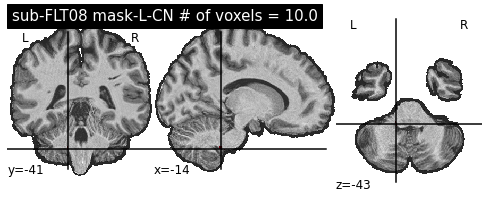

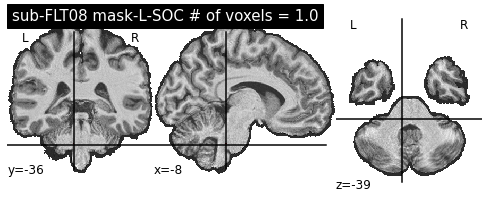

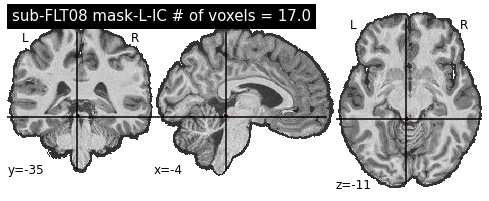

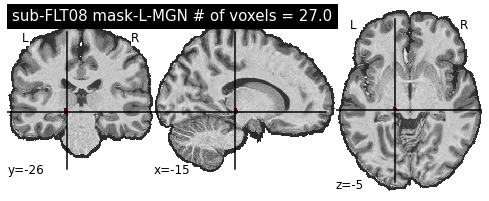

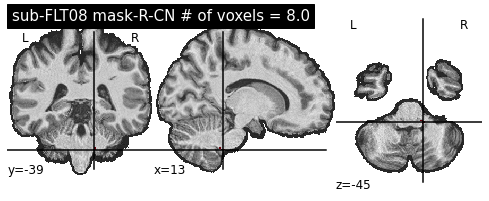

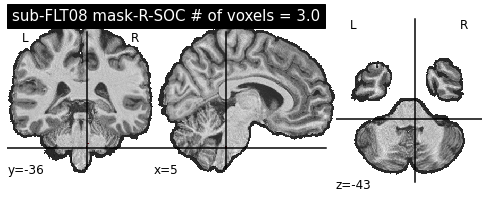

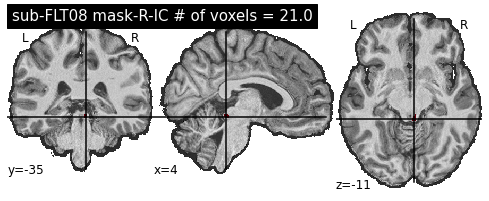

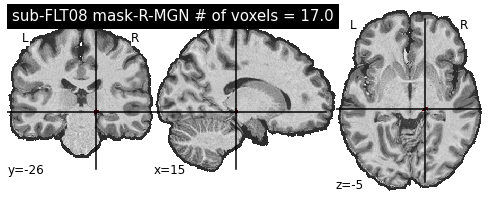

In [24]:
space_label = 'MNI152NLin2009cAsym'
roi_list = list(roi_dict.keys())

for sub_id in ['FLT08']: #sub_list:
    t1w_fpath = os.path.join('/bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/',
                           'sub-{}/anat'.format(sub_id),
                           'sub-{}_space-{}_desc-preproc_T1w.nii.gz'.format(sub_id, space_label))
    
    masks_dir = os.path.join(nilearn_dir, 'masks', 'sub-%s'%sub_id, 'space-%s'%space_label, 'masks-subcort-aud')#, 'masks-aparc' 'masks-subcort-aud'
    for mx, mask_descrip in enumerate(roi_list):
        # define the mask for the region of interest
        mask_fpath = os.path.join(masks_dir, 'sub-%s_space-%s_mask-%s.nii.gz'%(sub_id, space_label, mask_descrip))
        
        mask_data = nib.load(mask_fpath).get_fdata()
        num_voxels = sum(sum(sum(mask_data)))

        display = plotting.plot_img(mask_fpath, bg_img=t1w_fpath, 
                                    title='sub-{} mask-{} # of voxels = {}'.format(sub_id, mask_descrip, num_voxels),
                                    threshold=0.5,
                                    vmin=0.5,
                                    cmap='Reds', 
                                    black_bg=False,
                                    #colorbar=True,
                                    )
        plotting.show()

## Extract atlas values

In [50]:
import os
from glob import glob
import nibabel as nib
from nilearn.maskers import NiftiLabelsMasker
from numpy import savetxt

In [51]:
atlas_fpath = os.path.join('/bgfs/bchandrasekaran/krs228/data/',
                           'reference/', #tpl-MNI152NLin2009cAsym/',
                           'tpl-MNI152NLin2009cAsym_res-01_desc-carpet_dseg.nii.gz') 
project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')
bidsroot = os.path.join(project_dir,'data_bids_noIntendedFor')

In [54]:
masker = NiftiLabelsMasker(labels_img=atlas_fpath, standardize=False,
                           memory='nilearn_cache', verbose=2)

In [57]:
fwhm = 1.5
sub_id = 'FLT08'
space_label = 'MNI152NLin2009cAsym'
nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                               'level-1_fwhm-%.02f'%fwhm, 
                               'sub-%s_space-%s'%(sub_id, space_label))    
stat_maps = sorted(glob(nilearn_sub_dir+'/trial_models/run*/*di*resid*.nii.gz'))
out_dir = os.path.join(nilearn_sub_dir, 'atlas_stat_vals')
os.makedirs(out_dir, exist_ok=True)

In [ ]:

for stat_fpath in stat_maps:
    stat_base = os.path.splitext(os.path.splitext(os.path.basename(stat_fpath))[0])[0]
    print(stat_base)
    
    atlas_values = masker.fit_transform(stat_fpath)[0]

    out_fpath = os.path.join(out_dir, stat_base+'_atlas-carpet'+'.tsv')
    savetxt(out_fpath, atlas_values, delimiter='/t')

sub-FLT08_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di1_aN_trial1_run00_map-residuals
[NiftiLabelsMasker.fit_transform] loading data from /bgfs/bchandrasekaran/krs228/data/reference/tpl-MNI152NLin2009cAsym_res-01_desc-carpet_dseg.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-MNI152NLin2009cAsym/trial_models/run00/sub-FLT08_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di1_aN_trial1_run00_map-residuals.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/bgfs/bchandrasekaran/krs228/data/reference/tpl-MNI152NLin2009cAsym_res-01_desc-carpet_dseg.nii.gz',
  'low_pass': None,
  'mask_img': None,
  '

In [59]:
len(atlas_values)

116

In [60]:
from numpy import genfromtxt

In [61]:
x = genfromtxt(out_fpath)

In [62]:
x

array([ 6.96684479e-17,  1.02318001e-15, -6.07797488e-15, -5.35629255e-15,
       -3.87985914e-16, -1.10155505e-15, -8.36029873e-15, -9.09717456e-15,
        3.48460610e-15, -8.15042145e-15, -6.12165889e-15,  8.81536060e-16,
        1.51502461e-15, -7.24548007e-15, -8.78586917e-15,  1.87738356e-15,
        4.70963392e-16, -5.92645743e-15, -1.98965092e-15, -3.99215805e-15,
       -9.61420054e-16, -3.30446888e-15, -2.68346476e-15, -3.47883522e-15,
       -1.55243006e-15, -1.04452669e-15,  4.68459892e-15, -2.01974182e-15,
        4.32109239e-15, -2.08422595e-15,  1.34482806e-15, -2.94299654e-15,
       -1.82021879e-15,  1.48623120e-15,  2.42316560e-15, -4.43968969e-15,
        4.76327008e-15, -3.13672138e-15,  8.21585006e-16,  6.51406461e-15,
        6.48405891e-15,  1.73786245e-15,  3.29565425e-15,  4.95926750e-15,
        5.81944051e-15, -6.72587787e-15, -2.58129735e-15,  3.18135875e-15,
       -3.06521160e-16,  9.11238561e-16,  2.42605455e-15, -4.36809942e-15,
        9.00886956e-16,  